In [1]:
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
%matplotlib inline
from time import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [2]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%10000==1:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        #side = int(np.sqrt(batch.shape[1]))
        side =batch.shape[1]
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 80
        side_square = 5
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [3]:

def create_z():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(0.0))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool = tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image, scope, n_dim_z):
        with tf.variable_scope(scope):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
        return fully_connected_output
    
    with tf.variable_scope("model_params"):
        z = conv_and_fc(real_entire_tiled,"conv_1", n_dim_z1)
        #zs = conv_and_fc(scrambled_entire_tiled,"conv_2",n_dim_z2)
        zs = fc(tf.reshape(scrambled_entire_tiled,[batch_size,side*side]), n_dim_z2)
        #zz = tf.concat([z,zs],axis=1)
        z1 = tf.reshape(fc(z, n_squares*n_dim_z), [-1, n_squares, n_dim_z])
        z2 = tf.reshape(fc(zs, n_squares*n_dim_z), [-1, n_dim_z, n_squares])
        cost = tf.matmul(tf.sigmoid(z1),tf.nn.sigmoid(z2))
        #cost = tf.nn.sigmoid(tf.reshape(fc(z, n_squares*n_squares), [-1, n_squares,  n_squares]))
        
    return z,zs,cost

In [4]:
# Define model params
batch_size = 20
n_iter_sinkhorn2 = 10
n_iter_sinkhorn = 200

temp = 2.0
temp2 =0.001

#mnist data
n_squares_side = 16
lr = 0.0001
n_channels = 1
rfield_size = 3
stride = 3
n_units = 6
keep_prob = 1.0
side_real = 28
opt = 'adam'
samples_per_num = 1
n_squares = n_squares_side **2
n_gromov = 5
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)
print(n_dim)
n_dim_z = 128
n_dim_z1 = 10
n_dim_z2 = 64

noise_factor = 0
np.random.seed(2)

ims0,_=data_train.next_batch(1)
ims0 = np.expand_dims(np.reshape(ims0, [-1, side_real,side_real]),axis=3)
ims0[ims0>0.5]=1
ims0[ims0<0.5]=0



nx = np.nansum(ims0) 
prop = nx/(side_real**2)*np.random.uniform(1.5,2.0)
pieces_split = np.zeros((batch_size, n_squares, side_square, side_square, 1))
for j in range(int(n_squares*prop)):
    pieces_split[:,j,:,:] = 1

scrambled_pieces_split = np.zeros(pieces_split.shape)



25


In [5]:
print(prop)

0.19335011239180147


In [6]:
#Now we define the main TF variables

scrambled_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
scrambled_split_tiled = tf.tile(scrambled_split, [samples_per_num, 1, 1, 1, 1])

stack_scrambled_pieces_split = tf.placeholder(tf.float32,[None, side_square, side_square, n_channels])

real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])

stack_real_images_split = tf.placeholder(tf.float32,[None, side_square, side_square, n_channels])

real_entire = tf.placeholder(tf.float32,[None, side_real, side_real, n_channels])
real_entire_tiled = tf.tile(real_entire,[samples_per_num,1,1,1])

scrambled_entire = tf.placeholder(tf.float32,[None, side, side, n_channels])
scrambled_entire_tiled = tf.tile(scrambled_entire,[samples_per_num,1,1,1])

temperature = tf.constant(temp, dtype=tf.float32)
global_step = tf.Variable(0, trainable=False)



Instructions for updating:
Colocations handled automatically by placer.


In [7]:

scrambled_split_tiled = tf.reshape(scrambled_split_tiled, [-1, n_squares, side_square ** 2* n_channels])
real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2* n_channels])

#ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)

z,z2, cost= create_z()
(soft_perms_inf2, _) = sinkhorn_ops.gumbel_sinkhorn(-cost, temp2, samples_per_num, noise_factor, n_iter_sinkhorn2, squeeze=False)
inv_soft_perms2 = tf.transpose(soft_perms_inf2, [0, 1, 3, 2])
inv_soft_perms2_flat = tf.reshape(tf.transpose(inv_soft_perms2, [1, 0, 2, 3]), [-1, n_squares, n_squares])

ordered_inf2 = tf.matmul(inv_soft_perms2_flat, scrambled_split_tiled)
 

l2s_diff = tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))
#l2s_diff = tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))

opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
nperms = 200
perms = np.zeros((nperms, n_squares))
for k in range(nperms):
    perms[k,:] = np.random.permutation(n_squares)
from copy import deepcopy
init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)
new = tf.trainable_variables()
print(new)
n_iter = 20000

for i in range(n_iter):
    

    ims0,_=data_train.next_batch(batch_size)
    ims0 = np.expand_dims(np.reshape(ims0, [-1, side_real,side_real]),axis=3)
    ims0[ims0>0.5]=1
    ims0[ims0<0.5]=0



    
    pieces_split = np.zeros((batch_size, n_squares, side_square, side_square, 1))
    scrambled_pieces_split = np.zeros(pieces_split.shape)

    
    for j in range(batch_size):
        nx = np.nansum(ims0[j,:,:,:]) 
        prop = nx/(side_real**2)*np.random.uniform(1.0,1.0)
    
        for k in range(int(n_squares*prop)):
            pieces_split[j,k,:,:] = 1
        perm = np.random.permutation(n_squares)
        #perm = np.arange(n_squares)
        #perm = perms[np.random.choice(nperms,1),:][0,:].astype(int)
        scrambled_pieces_split[j,:,:,:] = deepcopy(pieces_split[j, perm, :, :])
        #scrambled_pieces_split[j,:,:,:] = deepcopy(pieces_split[j, perm[0,:].astype(int), :, :])
        
    stacked_scrambled_pieces_split = stack_batch_split(scrambled_pieces_split)
    ims_scrambled = join_batch_split(scrambled_pieces_split)

    if i<n_iter-1:
        ims,_=data_train.next_batch(batch_size)
    else:
        print('hola')
        ims,_=data_test.next_batch(batch_size)        
    ims = np.expand_dims(np.reshape(ims, [-1, 28,28]),axis=3)
    ims[ims>0.5]=1
    ims[ims<0.5]=0
    np_x = resize_batch_color(ims, side, n_channels)

    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    stacked_real_images_split = stack_batch_split(real_images_split)

    [o2,loss, _, sp2,cos,z2n] = sess.run([ordered_inf2, l2s_diff, train_op, soft_perms_inf2,cost,scrambled_entire],{real_split:real_images_split,
                                 scrambled_split:scrambled_pieces_split,
                                 stack_scrambled_pieces_split:stacked_scrambled_pieces_split,
                                                                                stack_real_images_split:stacked_real_images_split,
                                                                               real_entire:ims,
                                                                                         scrambled_entire:ims_scrambled})
    if(i%10==0):
        print([i, loss, int(n_squares*prop)])
 
   # if i==n_iter-1:
#         ims,_=data_train.next_batch(batch_size)
#         [zn] = sess.run([ordered_inf2],{
#                                      scrambled_split:scrambled_pieces_split,
#                                      stack_scrambled_pieces_split:stacked_scrambled_pieces_split})



Instructions for updating:
Use `tf.global_variables_initializer` instead.
[<tf.Variable 'model_params/conv_1/weights:0' shape=(3, 3, 1, 6) dtype=float32_ref>, <tf.Variable 'model_params/conv_1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected/weights:0' shape=(600, 10) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected/biases:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_1/weights:0' shape=(6400, 64) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_2/weights:0' shape=(10, 32768) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_2/biases:0' shape=(32768,) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_3/weights:0' shape=(64, 32768) dtype=float32_ref>, <tf.Variable 'model_params/fully_connected_3/biases:0' shape=(32768,) dtype=float32_ref>]


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


[0, 0.106062554, 20]
[10, 0.09482966, 16]
[20, 0.097950056, 42]
[30, 0.100872874, 29]
[40, 0.09447429, 13]
[50, 0.09947964, 12]
[60, 0.09901602, 25]
[70, 0.08842053, 23]
[80, 0.09716548, 32]
[90, 0.09095243, 35]
[100, 0.09186798, 41]
[110, 0.09226824, 51]
[120, 0.08825781, 25]
[130, 0.08579934, 24]
[140, 0.09091242, 34]
[150, 0.08123781, 20]
[160, 0.086855374, 29]
[170, 0.08058281, 40]
[180, 0.089941286, 17]
[190, 0.08235246, 26]
[200, 0.082549065, 6]
[210, 0.09768294, 26]
[220, 0.082940325, 31]
[230, 0.08577012, 24]
[240, 0.08974008, 25]
[250, 0.092056446, 20]
[260, 0.09043512, 36]
[270, 0.08376297, 54]
[280, 0.08014072, 36]
[290, 0.09096811, 35]
[300, 0.09132188, 30]
[310, 0.08674109, 21]
[320, 0.087046735, 28]
[330, 0.08636402, 22]
[340, 0.08504482, 20]
[350, 0.08393091, 52]
[360, 0.08299561, 48]
[370, 0.08892861, 23]
[380, 0.084516145, 30]
[390, 0.08867194, 27]
[400, 0.08406668, 29]
[410, 0.08058948, 19]
[420, 0.092292055, 33]
[430, 0.08693291, 42]
[440, 0.0915186, 19]
[450, 0.0858

[3590, 0.07559906, 47]
[3600, 0.06848818, 55]
[3610, 0.076459356, 42]
[3620, 0.08404564, 29]
[3630, 0.07898608, 39]
[3640, 0.0767657, 17]
[3650, 0.08120592, 39]
[3660, 0.07723701, 29]
[3670, 0.070441514, 22]
[3680, 0.07419505, 36]
[3690, 0.08222876, 36]
[3700, 0.07743563, 25]
[3710, 0.0764341, 35]
[3720, 0.06982131, 36]
[3730, 0.08156064, 44]
[3740, 0.077539794, 35]
[3750, 0.08443606, 42]
[3760, 0.06603617, 39]
[3770, 0.07391809, 20]
[3780, 0.076344095, 22]
[3790, 0.08031554, 49]
[3800, 0.07909794, 40]
[3810, 0.07383606, 31]
[3820, 0.07192102, 60]
[3830, 0.08357823, 27]
[3840, 0.0795297, 37]
[3850, 0.067441605, 45]
[3860, 0.06747394, 41]
[3870, 0.08553572, 42]
[3880, 0.08353562, 28]
[3890, 0.07947793, 52]
[3900, 0.07401466, 38]
[3910, 0.0808557, 33]
[3920, 0.08127061, 22]
[3930, 0.073519394, 35]
[3940, 0.07880962, 47]
[3950, 0.06604608, 28]
[3960, 0.07442987, 26]
[3970, 0.075270206, 19]
[3980, 0.08063252, 42]
[3990, 0.091482416, 57]
[4000, 0.070674196, 11]
[4010, 0.07846748, 54]
[4020,

[7120, 0.062372953, 58]
[7130, 0.066428974, 42]
[7140, 0.061443053, 21]
[7150, 0.06444557, 34]
[7160, 0.06425392, 43]
[7170, 0.06729349, 46]
[7180, 0.07001757, 53]
[7190, 0.06540605, 30]
[7200, 0.0678834, 24]
[7210, 0.05869942, 31]
[7220, 0.064836554, 37]
[7230, 0.06213145, 57]
[7240, 0.06977464, 17]
[7250, 0.07039737, 49]
[7260, 0.0643275, 15]
[7270, 0.071206406, 22]
[7280, 0.061513115, 26]
[7290, 0.059691377, 45]
[7300, 0.07443007, 66]
[7310, 0.06766217, 39]
[7320, 0.06564443, 46]
[7330, 0.05489312, 32]
[7340, 0.060977306, 38]
[7350, 0.06902335, 43]
[7360, 0.058832366, 41]
[7370, 0.06445053, 40]
[7380, 0.071676165, 14]
[7390, 0.06522493, 40]
[7400, 0.06736029, 28]
[7410, 0.07428308, 47]
[7420, 0.05705031, 30]
[7430, 0.0660207, 16]
[7440, 0.06511991, 40]
[7450, 0.059361845, 38]
[7460, 0.061628815, 40]
[7470, 0.06585373, 34]
[7480, 0.060906723, 36]
[7490, 0.059830025, 29]
[7500, 0.06527487, 24]
[7510, 0.06328233, 18]
[7520, 0.06222663, 28]
[7530, 0.057415508, 33]
[7540, 0.058097612, 24

[10580, 0.045235995, 22]
[10590, 0.046510763, 29]
[10600, 0.047107235, 32]
[10610, 0.045610785, 35]
[10620, 0.052418265, 53]
[10630, 0.047029372, 40]
[10640, 0.050685752, 25]
[10650, 0.04279689, 46]
[10660, 0.050115563, 39]
[10670, 0.05432546, 38]
[10680, 0.044482864, 33]
[10690, 0.053565163, 17]
[10700, 0.045339838, 20]
[10710, 0.052908204, 35]
[10720, 0.045693826, 18]
[10730, 0.047490507, 44]
[10740, 0.0439169, 26]
[10750, 0.052570883, 37]
[10760, 0.049603652, 38]
[10770, 0.046776835, 28]
[10780, 0.04755208, 32]
[10790, 0.0528131, 41]
[10800, 0.05132169, 57]
[10810, 0.05256317, 26]
[10820, 0.049533036, 36]
[10830, 0.050852835, 30]
[10840, 0.045637302, 39]
[10850, 0.038869597, 28]
[10860, 0.051178772, 32]
[10870, 0.046881545, 48]
[10880, 0.04900713, 34]
[10890, 0.042785794, 34]
[10900, 0.04651865, 32]
[10910, 0.050206732, 29]
[10920, 0.05078253, 43]
[10930, 0.052159715, 52]
[10940, 0.051710144, 30]
[10950, 0.050308723, 40]
[10960, 0.048806928, 20]
[10970, 0.044058777, 41]
[10980, 0.04

[13910, 0.04474591, 30]
[13920, 0.04318927, 43]
[13930, 0.037724454, 32]
[13940, 0.04742434, 28]
[13950, 0.044680115, 34]
[13960, 0.042214103, 18]
[13970, 0.04760959, 23]
[13980, 0.043140933, 21]
[13990, 0.042931005, 23]
[14000, 0.041412774, 13]
[14010, 0.045270346, 16]
[14020, 0.047895774, 35]
[14030, 0.0406703, 48]
[14040, 0.044743743, 48]
[14050, 0.043145925, 27]
[14060, 0.040829252, 26]
[14070, 0.043699816, 23]
[14080, 0.047782287, 51]
[14090, 0.037809405, 31]
[14100, 0.047277264, 56]
[14110, 0.046778876, 46]
[14120, 0.042546242, 20]
[14130, 0.044995073, 31]
[14140, 0.04413818, 40]
[14150, 0.043299265, 51]
[14160, 0.044752494, 19]
[14170, 0.046319306, 39]
[14180, 0.040754065, 8]
[14190, 0.044113, 29]
[14200, 0.04032026, 26]
[14210, 0.039327595, 29]
[14220, 0.046134662, 23]
[14230, 0.039393082, 14]
[14240, 0.04270831, 26]
[14250, 0.041415725, 48]
[14260, 0.036727235, 35]
[14270, 0.044124637, 26]
[14280, 0.03822883, 22]
[14290, 0.042918365, 32]
[14300, 0.0390444, 32]
[14310, 0.043835

[17260, 0.04095469, 29]
[17270, 0.039690908, 18]
[17280, 0.045368284, 58]
[17290, 0.039868925, 46]
[17300, 0.046437, 24]
[17310, 0.040664844, 39]
[17320, 0.043231998, 35]
[17330, 0.042257857, 22]
[17340, 0.04140768, 22]
[17350, 0.04461449, 31]
[17360, 0.048978303, 38]
[17370, 0.04225656, 26]
[17380, 0.031924874, 35]
[17390, 0.038406577, 52]
[17400, 0.03801514, 35]
[17410, 0.044596374, 48]
[17420, 0.04041581, 16]
[17430, 0.041432414, 19]
[17440, 0.037000388, 40]
[17450, 0.041873086, 36]
[17460, 0.037623223, 33]
[17470, 0.04243157, 34]
[17480, 0.043694124, 36]
[17490, 0.042650767, 28]
[17500, 0.049163003, 42]
[17510, 0.03774508, 57]
[17520, 0.046768986, 31]
[17530, 0.045943327, 53]
[17540, 0.04438505, 42]
[17550, 0.043891113, 30]
[17560, 0.042335242, 35]
[17570, 0.046787538, 33]
[17580, 0.038989592, 33]
[17590, 0.04243976, 13]
[17600, 0.04122579, 36]
[17610, 0.04896167, 61]
[17620, 0.03750893, 34]
[17630, 0.03824299, 18]
[17640, 0.044195022, 37]
[17650, 0.04038095, 51]
[17660, 0.0429366,

In [9]:
batch_size_display = batch_size
hard = np.zeros(sp2.shape)

for i in range(batch_size_display):
    hard[i,0,:,:] =soft_to_hard(np.transpose(sp2[i,0,:,:]))
unscrambled_images_hard =  np.matmul(hard[:,0,:,:], np.reshape(scrambled_pieces_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
unscrambled_images_soft =  o2
unflatten_inf_hard = unflatten_batch(unscrambled_images_hard, n_channels)
joined_inf_hard = join_batch_split(unflatten_inf_hard)
unflatten_inf_soft = unflatten_batch(unscrambled_images_soft, n_channels)
joined_inf_soft = join_batch_split(unflatten_inf_soft)


(20, 80, 80, 1)


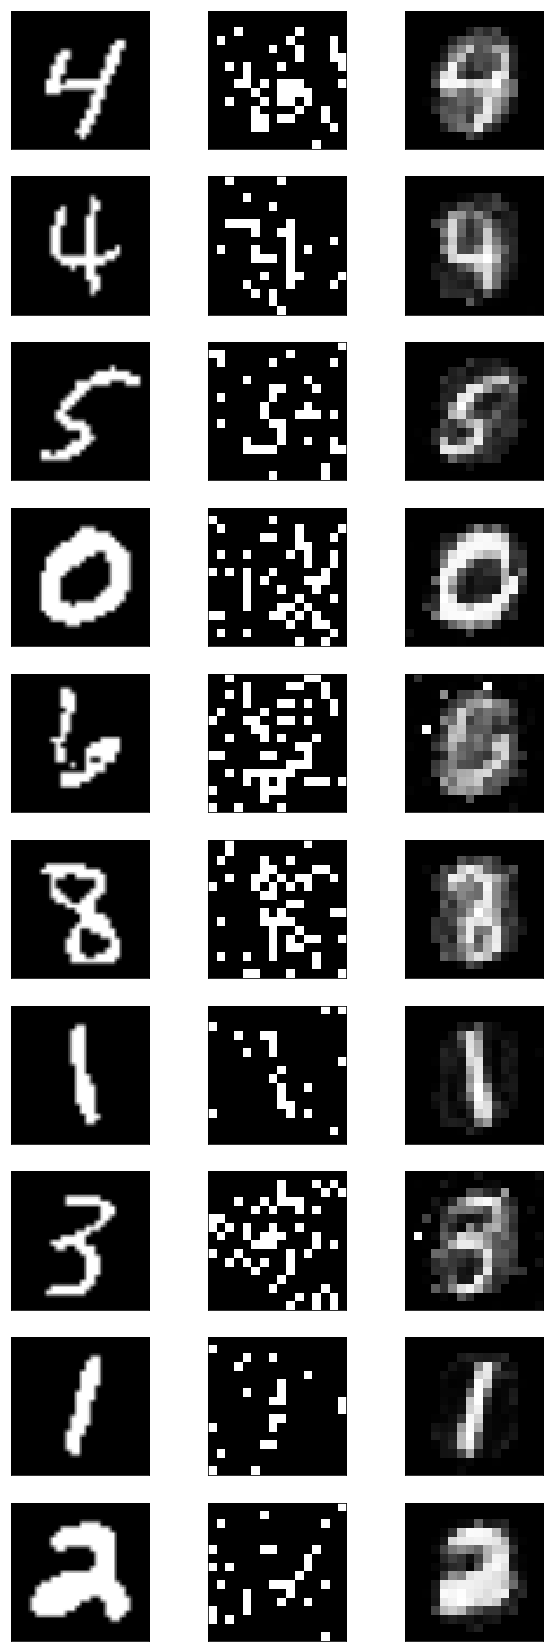

In [10]:
fig,ax=plt.subplots(10,3,figsize=(10,30))
#plt.imshow(joined_inf[0,:,:,0])
print(np_x.shape)
for i in range(10):
    
    ax[i,0].imshow(np_x[i,:,:,0],'gray')
    ax[i,1].imshow(joined_inf_hard[i,:,:,0],'gray')
    ax[i,2].imshow(joined_inf_soft[i,:,:,0],'gray')
    for k in range(3):
        ax[i,k].get_xaxis().set_visible(False)
        ax[i,k].get_yaxis().set_visible(False)

[ 0.19143209  0.9321425   3.9838939   0.85317785  0.75586486  0.34284458
  1.024906    0.7950467   0.74158454  0.65723675  0.39402437  0.17006546
  0.1551609   1.1385713   0.26456478  3.6833165   0.760213    1.1403247
  0.14870588  0.22472222  0.21029851  0.14500403  0.14222826  2.994648
  0.32483122  4.8173065   0.14494789  1.3019731   0.15398684  0.15074399
  0.15868688  0.80787456  0.7776701   1.1260747   0.14287284  3.4940674
  4.733619    0.14420786  0.95455927  1.9250528   0.7662449   0.7411137
  0.8502263   1.2511458   0.15399276  1.6577755   0.16797008  0.18422759
  0.43062788  0.32372385  0.14676607  0.14368863  0.27019823  1.4074227
  0.14417678  0.14199701  0.7944782   1.1970841   3.8512452   0.47617558
  0.41332108  2.447933    0.19147584  0.31240776  0.18633598  0.15167104
  0.81223035  0.15716599  0.14359578  0.44845286  0.13912681  0.9892892
  0.96163976  1.3515178   0.24350242  0.15472172  0.20772602  0.23538068
  0.9342756   0.85420454  0.15363842  0.5468591   0.889558

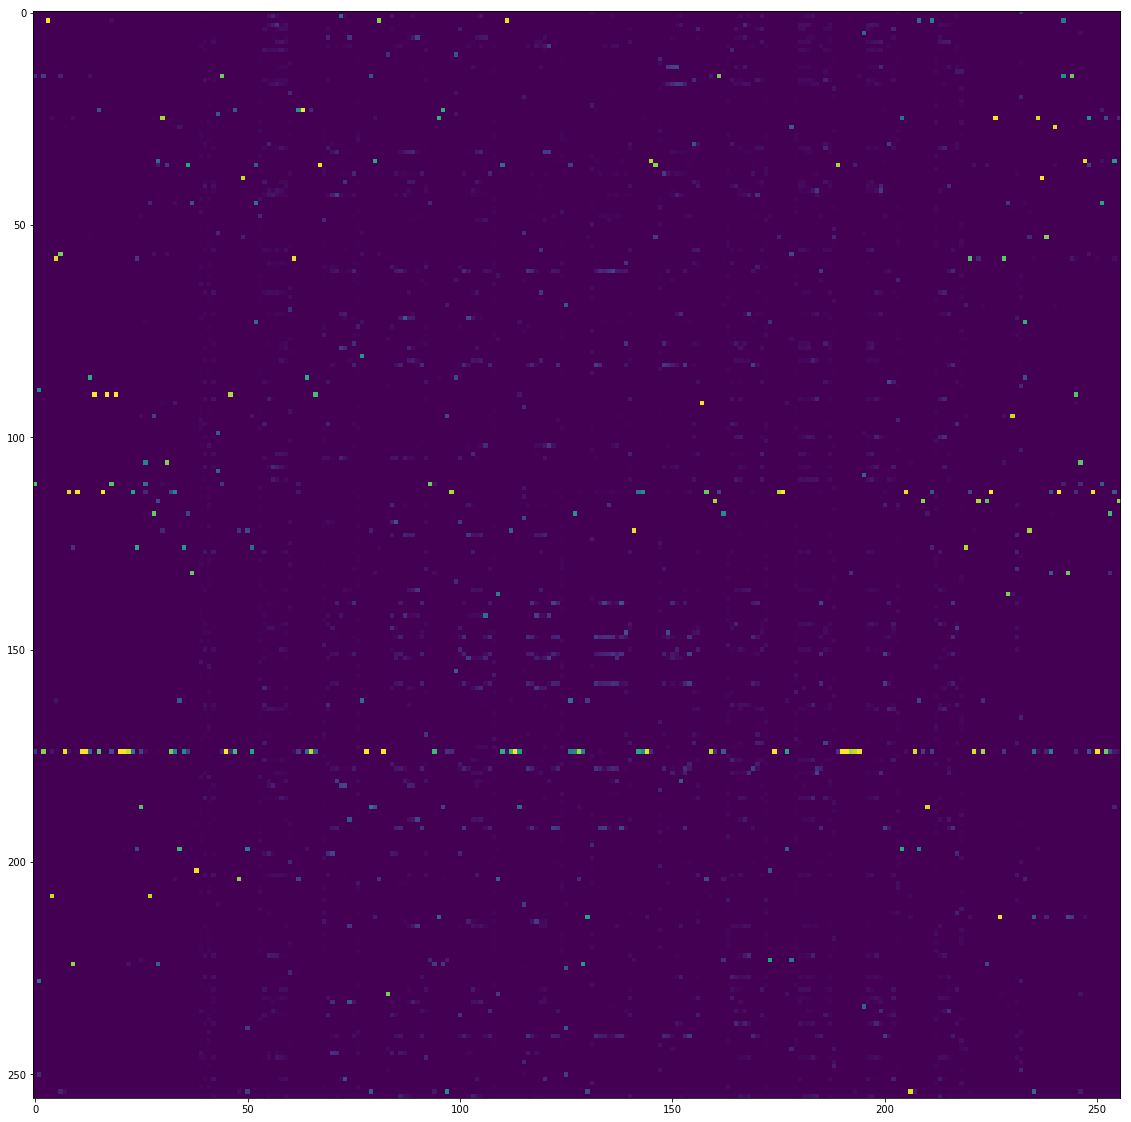

In [11]:
print(np.sum(sp2[0,0,:,:], axis=1))
plt.figure(figsize=(20,20))
plt.imshow(sp2[0,0,:,:])

8.78188775510204


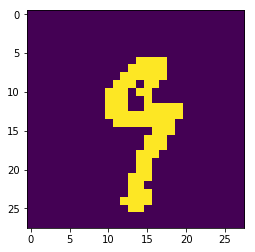

In [12]:

ims0,_=data_train.next_batch(1)
ims0 = np.expand_dims(np.reshape(ims0, [-1, side_real,side_real]),axis=3)
ims0[ims0>0.5]=1
ims0[ims0<0.5]=0

print(81*np.nansum(ims0)/784)
plt.imshow(ims0[0,:,:,0])


In [13]:
#Now we define the main TF variables
print(nx)

# data_pieces = tf.reshape(stack_scrambled_pieces_split, [batch_size, n_squares, n_dim])
# data_real = tf.reshape(stack_real_images_split, [batch_size, n_squares, n_dim])


# sq = tf.reduce_sum(data_pieces **2, axis=2, keepdims=True)
# A = tf.tile(sq, [1, 1, n_squares])
# B = tf.tile(tf.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
# C = -2*tf.matmul(data_pieces, tf.transpose(data_pieces, [0, 2, 1]))
# s1 = A+B +C

# sq2 = tf.reduce_sum(data_real **2, axis=2, keepdims=True)
# A2 = tf.tile(sq2, [1, 1, n_squares])
# B2 = tf.tile(tf.transpose(sq2, [0,2 ,1]), [1, n_squares, 1])
# C2 = -2*tf.matmul(data_real, tf.transpose(data_real, [0, 2, 1]))
# s2 = A2+B2 +C2


# f1 = tf.tile(tf.reduce_sum(s1**2, axis=2, keepdims=True),[1, 1, n_squares]) 
# f2 = tf.transpose(tf.tile(tf.reduce_sum(s2**2, axis=2, keepdims=True),[1, 1, n_squares]), [0, 2 ,1]) 
# soft_perms_inf = tf.cast(tf.tile(tf.constant(np.eye(n_squares))[np.newaxis,:,:],[batch_size, 1, 1]), tf.float32)
  
    
# for _ in range(n_gromov):
#     P = tf.reshape(soft_perms_inf, [-1, n_squares, n_squares])      
#     ma = -1*(f1+f2 - 2*tf.matmul(s1, tf.matmul(P, s2)))
#     (soft_perms_inf, _) = sinkhorn_ops.gumbel_sinkhorn(ma, temp, samples_per_num,
#                                                                        noise_factor, n_iter_sinkhorn, squeeze=False)

#inv_soft_perms = tf.transpose(soft_perms_inf, [0, 1, 3, 2])
#inv_soft_perms_flat = tf.reshape( tf.transpose(inv_soft_perms, [1, 0, 2, 3]), [-1, n_squares, n_squares])

113.0


In [14]:
plt.imshow()

TypeError: imshow() takes at least 1 argument (0 given)

In [ ]:

nx = np.nansum(ims0) 
prop = nx/(side**2)
print(prop)

In [ ]:
plt.imshow(ims0[0,:,:,0])

In [ ]:
int(n_squares*prop)

In [ ]:
print(side)

In [ ]:
np.random.seed(1)
perm = np.random.permutation(n_squares)
print(perm)